In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd
import statsmodels.api as sm

import bars
import c
import d
import simulation
import u

# Fetch Data

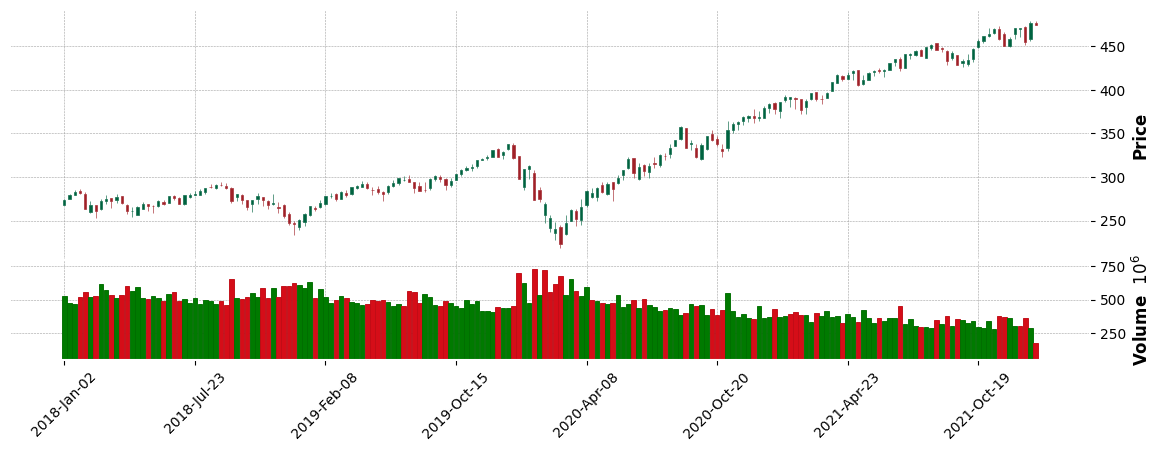

In [3]:
plt.rcParams["figure.figsize"] = (15, 5)

data = d.fetch("data/stock/daily", "SPY.csv")
data = data[(data.index.year >= 2018) & (data.index.year <= 2021)]
data["dv"] = data["Close"] * data["Volume"]
mean_weekly_dv = np.mean(data.resample("W-MON")["dv"].sum())
data = bars.create_dollar_volume_bars(data, mean_weekly_dv)
mplf.plot(data, type="candle", style="charles", figsize=(15, 5), volume=True)

# Estimate Parameters

In [4]:
estimates = simulation.estimate_ou_parameters(
    data["Close"], data["Close"].iloc[0], as_series=True
)
estimates

rho       1.001584
stddev    8.973358
dtype: float64

# Run Simulation

In [5]:
%%time

max_holding_period = 50
rho = estimates["rho"]
stddev = estimates["stddev"]
start_price = data["Close"].iloc[0]
target = stddev / start_price

mesh = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 9, 10]

results = simulation.simulate_price_target_stop_loss_mesh(
    n_samples_per_point=1200,
    target=target,
    price_targets=mesh,
    stop_losses=mesh,
    side=c.Dir.B,
    price_data_args={
        "theta": 0,
        "start_price": start_price,
        "stddev": stddev,
        "use_exp": False,
        "n_samples": max_holding_period,
        "rho": rho,
    },
)
results["sharpe"] = results["profit_mean"] / results["profit_stddev"]

CPU times: total: 40min 58s
Wall time: 40min 59s


# Sharpe Ratio vs Price Targets/Stop Losses

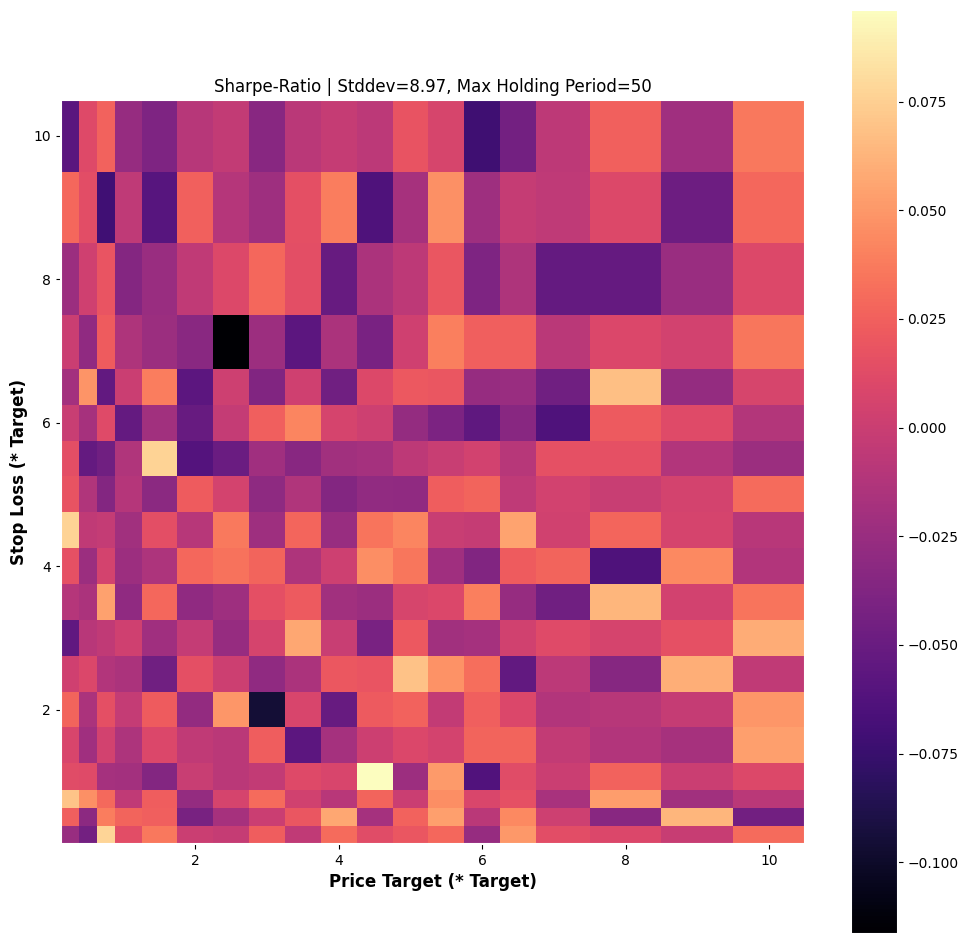

In [6]:
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams["axes.grid"] = False

shape = (len(mesh), len(mesh))
plt.pcolormesh(
    results["pt"].values.reshape(shape),
    results["sl"].values.reshape(shape),
    results["sharpe"].values.reshape(shape),
    cmap="magma",
)
plt.xlabel("Price Target (* Target)")
plt.ylabel("Stop Loss (* Target)")
plt.title(
    f"Sharpe-Ratio | Stddev={stddev:.2f}, Max Holding Period={max_holding_period}"
)
plt.colorbar()
plt.gca().set_box_aspect(1)

# Optimal Trade Rule

In [7]:
print(f"Target (as fraction of price): {target:.5f}")
results.loc[results["sharpe"].idxmax()]

Target (as fraction of price): 0.03274


pt                                                             4.5
sl                                                             1.0
profit           [-14.29000000000002, -17.569999999999993, -32....
profit_mean                                                 2.6048
profit_stddev                                             27.11168
sharpe                                                    0.096077
Name: 193, dtype: object